In [2]:
!pip install tensorboard==2.17.0

     |████████████████████████████████| 5.5 MB 643 kB/s eta 0:00:01     |█████████████████████▎          | 3.7 MB 2.6 MB/s eta 0:00:01
     |████████████████████████████████| 6.6 MB 4.6 MB/s eta 0:00:01     |███████████████████████████▉    | 5.7 MB 4.6 MB/s eta 0:00:01
     |████████████████████████████████| 106 kB 9.2 MB/s eta 0:00:01
     |████████████████████████████████| 5.8 MB 5.7 MB/s eta 0:00:01     |███████████████████████████▏    | 4.9 MB 5.7 MB/s eta 0:00:01
     |████████████████████████████████| 294 kB 7.1 MB/s eta 0:00:01     |█████▋                          | 51 kB 7.3 MB/s eta 0:00:01
     |████████████████████████████████| 227 kB 9.9 MB/s eta 0:00:01
You should consider upgrading via the '/usr/local/bin/python -m pip install --upgrade pip' command.


In [14]:
from huggingface_hub import notebook_login

notebook_login()

In [3]:
processor_id="microsoft/layoutlmv2-base-uncased"
dataset_id ="nielsr/funsd"

In [4]:
from datasets import load_dataset

dataset = load_dataset(dataset_id)

print(f"Train dataset size: {len(dataset['train'])}")
print(f"Test dataset size: {len(dataset['test'])}")

Train dataset size: 149
Test dataset size: 50


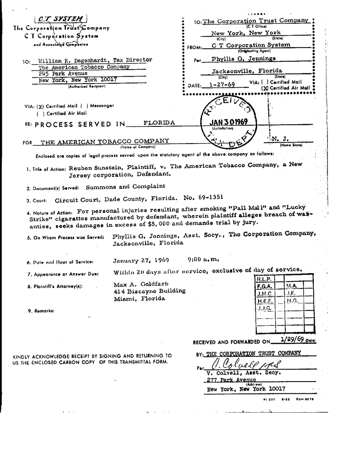

In [5]:
from PIL import Image, ImageDraw, ImageFont

image = Image.open(dataset['train'][34]['image_path'])
image = image.convert("RGB")
image.resize((350,450))

In [6]:
labels = dataset['train'].features['ner_tags'].feature.names
print(f"Available labels: {labels}")

id2label = {v: k for v, k in enumerate(labels)}
label2id = {k: v for v, k in enumerate(labels)}

Available labels: ['O', 'B-HEADER', 'I-HEADER', 'B-QUESTION', 'I-QUESTION', 'B-ANSWER', 'I-ANSWER']


In [26]:
from transformers import LayoutLMv2Processor

# use LayoutLMv2 processor without ocr since the dataset already includes the ocr text
processor = LayoutLMv2Processor.from_pretrained(processor_id, apply_ocr=False)

/usr/local/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [8]:
print(dataset["train"][0])

{'id': '0', 'words': ['R&D', ':', 'Suggestion:', 'Date:', 'Licensee', 'Yes', 'No', '597005708', 'R&D', 'QUALITY', 'IMPROVEMENT', 'SUGGESTION/', 'SOLUTION', 'FORM', 'Name', '/', 'Phone', 'Ext.', ':', 'M.', 'Hamann', 'P.', 'Harper,', 'P.', 'Martinez', '9/', '3/', '92', 'R&D', 'Group:', 'J.', 'S.', 'Wigand', 'Supervisor', '/', 'Manager', 'Discontinue', 'coal', 'retention', 'analyses', 'on', 'licensee', 'submitted', 'product', 'samples', '(Note', ':', 'Coal', 'Retention', 'testing', 'is', 'not', 'performed', 'by', 'most', 'licensees.', 'Other', 'B&W', 'physical', 'measurements', 'as', 'ends', 'stability', 'and', 'inspection', 'for', 'soft', 'spots', 'in', 'ciparettes', 'are', 'thought', 'to', 'be', 'sufficient', 'measures', 'to', 'assure', 'cigarette', 'physical', 'integrity.', 'The', 'proposed', 'action', 'will', 'increase', 'laboratory', 'productivity', '.', ')', 'Suggested', 'Solutions', '(s)', ':', 'Delete', 'coal', 'retention', 'from', 'the', 'list', 'of', 'standard', 'analyses', 'per

In [9]:
from PIL import Image
from functools import partial
from datasets import Features, Sequence, ClassLabel, Value, Array2D


# we need to define custom features
features = Features(
    {
        "input_ids": Sequence(feature=Value(dtype="int64")),
        "attention_mask": Sequence(Value(dtype="int64")),
        "token_type_ids": Sequence(Value(dtype="int64")),
        "bbox": Array2D(dtype="int64", shape=(512, 4)),
        "labels": Sequence(ClassLabel(names=labels)),
    }
)

# preprocess function to perpare into the correct format for the model
def process(sample, processor=None):
    encoding = processor(
        Image.open(sample["image_path"]).convert("RGB"),
        sample["words"],
        boxes=sample["bboxes"],
        word_labels=sample["ner_tags"],
        padding="max_length",
        truncation=True,
    )
    del encoding["image"]
    return encoding


# process the dataset and format it to pytorch
proc_dataset = dataset.map(
    partial(process, processor=processor),
    remove_columns=["image_path", "words", "ner_tags", "id", "bboxes"],
    features=features,
).with_format("torch")

print(proc_dataset["train"].features.keys())
# dict_keys(['input_ids', 'token_type_ids', 'attention_mask', 'bbox','lables'])


Map:   0%|          | 0/50 [00:00<?, ? examples/s]

dict_keys(['input_ids', 'attention_mask', 'token_type_ids', 'bbox', 'labels'])


In [10]:
#Fine tuning is done here
from transformers import LayoutLMForTokenClassification

# huggingface hub model id
model_id = "microsoft/layoutlm-base-uncased"

# load model with correct number of labels and mapping
model = LayoutLMForTokenClassification.from_pretrained(
    model_id, num_labels=len(labels), label2id=label2id, id2label=id2label
)

Some weights of LayoutLMForTokenClassification were not initialized from the model checkpoint at microsoft/layoutlm-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [11]:
import evaluate
import numpy as np

# load seqeval metric
metric = evaluate.load("seqeval")

# labels of the model
ner_labels = list(model.config.id2label.values())


def compute_metrics(p):
    predictions, labels = p
    predictions = np.argmax(predictions, axis=2)

    all_predictions = []
    all_labels = []
    for prediction, label in zip(predictions, labels):
        for predicted_idx, label_idx in zip(prediction, label):
            if label_idx == -100:
                continue
            all_predictions.append(ner_labels[predicted_idx])
            all_labels.append(ner_labels[label_idx])
    return metric.compute(predictions=[all_predictions], references=[all_labels])

In [12]:
!pip install --upgrade accelerate
import accelerate
print(accelerate.__version__)


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


You should consider upgrading via the '/usr/local/bin/python -m pip install --upgrade pip' command.
0.34.2


In [15]:
from huggingface_hub import HfFolder
from transformers import Trainer, TrainingArguments

# hugging face parameter
repository_id = "layoutlm-funsd"

# Define training args
training_args = TrainingArguments(
    output_dir=repository_id,
    num_train_epochs=5,
    per_device_train_batch_size=4,
    per_device_eval_batch_size=8,
    fp16=True,
    learning_rate=3e-5,
    # logging & evaluation strategies
    logging_dir=f"{repository_id}/logs",
    logging_strategy="epoch",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    save_total_limit=2,
    load_best_model_at_end=True,
    metric_for_best_model="overall_f1",
    # push to hub parameters
    report_to="tensorboard",
    push_to_hub=True,
    hub_strategy="every_save",
    hub_model_id=repository_id,
    hub_token=HfFolder.get_token(),
)

# Create Trainer instance
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=proc_dataset["train"],
    eval_dataset=proc_dataset["test"],
    compute_metrics=compute_metrics,
)

In [ ]:
# ## TRAIN THIS ON A GPU
# import logging
# logging.basicConfig(level=logging.INFO)
# # Starting the trainer
# trainer.train()

In [16]:
!apt-get update
!apt-get install -y tesseract-ocr
!apt-get install -y libtesseract-dev

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Get:1 http://deb.debian.org/debian bullseye InRelease [116 kB]
Get:2 http://security.debian.org/debian-security bullseye-security InRelease [27.2 kB]
Get:3 http://deb.debian.org/debian bullseye-updates InRelease [44.1 kB]
Get:4 http://security.debian.org/debian-security bullseye-security/main amd64 Packages [300 kB]
Get:5 http://deb.debian.org/debian bullseye/main amd64 Packages [8066 kB]
Get:6 http://deb.debian.org/debian bullseye-updates/main amd64 Packages [18.8 kB]
Fetched 8572 kB in 4s (2115 kB/s)                     
Reading package lists... Done


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  libarchive13 libgif7 liblept5 libtesseract4 tesseract-ocr-eng
  tesseract-ocr-osd
Suggested packages:
  lrzip
The following NEW packages will be installed:
  libarchive13 libgif7 liblept5 libtesseract4 tesseract-ocr tesseract-ocr-eng
  tesseract-ocr-osd
0 upgraded, 7 newly installed, 0 to remove and 170 not upgraded.
Need to get 7601 kB of archives.
After this operation, 23.6 MB of additional disk space will be used.
Get:1 http://deb.debian.org/debian bullseye/main amd64 libarchive13 amd64 3.4.3-2+deb11u1 [343 kB]
Get:2 http://deb.debian.org/debian bullseye/main amd64 libgif7 amd64 5.1.9-2 [45.1 kB]
Get:3 http://deb.debian.org/debian bullseye/main amd64 liblept5 amd64 1.79.0-1.1+deb11u1 [1027 kB]
Get:4 http://deb.debian.org/debian bullseye/main amd64 libtesseract4 amd64 4.1.1-2.1 [1274 kB]
Get:5 http://deb.debian.org/debian bullseye/mai

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  libarchive-dev libleptonica-dev
The following NEW packages will be installed:
  libarchive-dev libleptonica-dev libtesseract-dev
0 upgraded, 3 newly installed, 0 to remove and 170 not upgraded.
Need to get 3465 kB of archives.
After this operation, 15.7 MB of additional disk space will be used.
Get:1 http://deb.debian.org/debian bullseye/main amd64 libarchive-dev amd64 3.4.3-2+deb11u1 [519 kB]
Get:2 http://deb.debian.org/debian bullseye/main amd64 libleptonica-dev amd64 1.79.0-1.1+deb11u1 [1429 kB]
Get:3 http://deb.debian.org/debian bullseye/main amd64 libtesseract-dev amd64 4.1.1-2.1 [1517 kB]
Fetched 3465 kB in 2s (1950 kB/s)           
debconf: delaying package configuration, since apt-utils is not installed
Selecting previously unselected package libarchive-dev:amd64.
(Reading database ... 23485 files and directories currently insta

/usr/local/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
/usr/local/lib/python3.10/site-packages/transformers/models/layoutlmv2/feature_extraction_layoutlmv2.py:30: FutureWarning: The class LayoutLMv2FeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use LayoutLMv2ImageProcessor instead.
  warnings.warn(


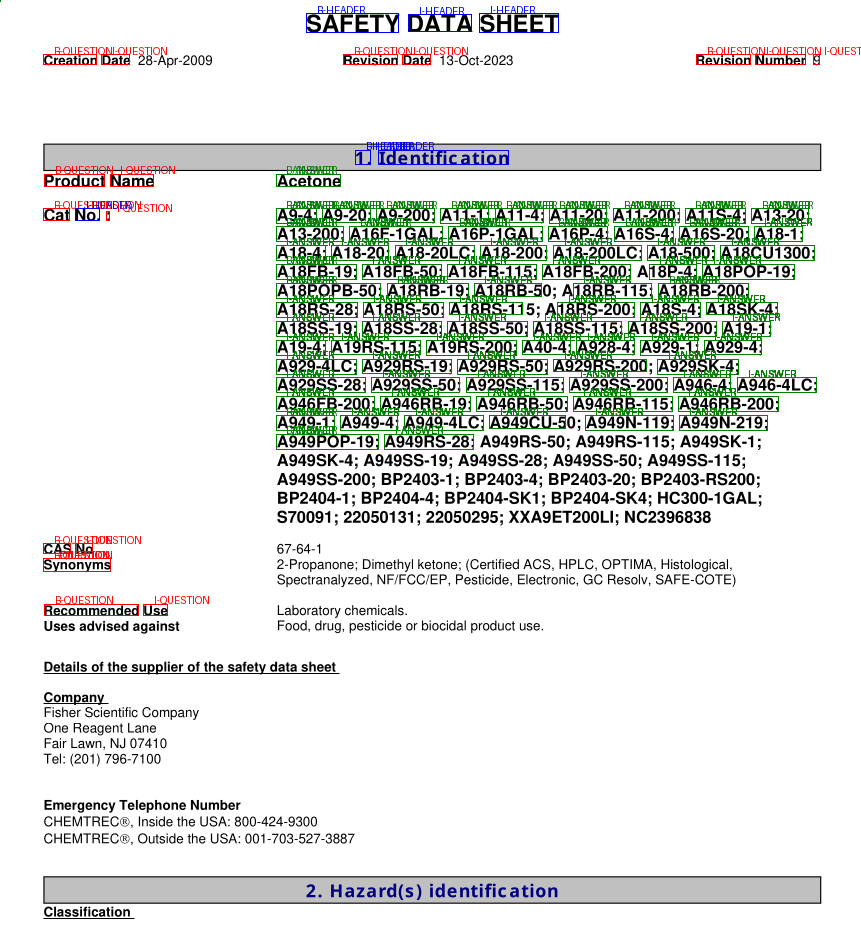

In [103]:
from transformers import LayoutLMForTokenClassification, LayoutLMv2Processor, LayoutLMv2FeatureExtractor, LayoutLMv2TokenizerFast
from PIL import Image, ImageDraw, ImageFont
import torch

# load model and processor from huggingface hub
# You are supposed to load your own trained model here
model = LayoutLMForTokenClassification.from_pretrained("philschmid/layoutlm-funsd")
processor = LayoutLMv2Processor.from_pretrained("microsoft/layoutlmv2-base-uncased",apply_ocr=True)
feature_extractor = LayoutLMv2FeatureExtractor.from_pretrained("microsoft/layoutlmv2-base-uncased")
tokenizer = LayoutLMv2TokenizerFast.from_pretrained("microsoft/layoutlmv2-base-uncased",apply_ocr=True)


# helper function to unnormalize bboxes for drawing onto the image
def unnormalize_box(bbox, width, height):
    return [
        width * (bbox[0] / 1000),
        height * (bbox[1] / 1000),
        width * (bbox[2] / 1000),
        height * (bbox[3] / 1000),
    ]


label2color = {
    "B-HEADER": "blue",
    "B-QUESTION": "red",
    "B-ANSWER": "green",
    "I-HEADER": "blue",
    "I-QUESTION": "red",
    "I-ANSWER": "green",
}
# draw results onto the image
def draw_boxes(image, boxes, predictions):
    width, height = image.size
    normalizes_boxes = [unnormalize_box(box, width, height) for box in boxes]

    # draw predictions over the image
    draw = ImageDraw.Draw(image)
    font = ImageFont.load_default()
    for prediction, box in zip(predictions, normalizes_boxes):
        if prediction == "O":
            continue
        draw.rectangle(box, outline="black")
        draw.rectangle(box, outline=label2color[prediction])
        draw.text((box[0] + 10, box[1] - 10), text=prediction, fill=label2color[prediction], font=font)
    return image


# run inference
def run_inference(path, model=model, processor=processor, output_image=True):
    # create model input
    image = Image.open(path).convert("RGB")
    image = image.convert("RGB")
    image.resize((350,450))
    image
    encoding = processor(image, return_tensors="pt", truncation=True)
    del encoding["image"]
    # run inference
    outputs = model(**encoding)

    predictions = outputs.logits.argmax(-1).squeeze().tolist()
    # get labels
    labels = [model.config.id2label[prediction] for prediction in predictions]
    words = encoding.get("words",None)
    if output_image:
        return draw_boxes(image, encoding["bbox"][0], labels)
    else:
        return labels,words


new_image = run_inference("Screenshot from 2024-10-06 21-57-15.png")
new_image


You are using a model of type layoutlmv2 to instantiate a model of type layoutlm. This is not supported for all configurations of models and can yield errors.
Some weights of LayoutLMForTokenClassification were not initialized from the model checkpoint at nielsr/layoutlmv2-finetuned-funsd and are newly initialized: ['layoutlm.embeddings.LayerNorm.bias', 'layoutlm.embeddings.LayerNorm.weight', 'layoutlm.embeddings.h_position_embeddings.weight', 'layoutlm.embeddings.position_embeddings.weight', 'layoutlm.embeddings.token_type_embeddings.weight', 'layoutlm.embeddings.w_position_embeddings.weight', 'layoutlm.embeddings.word_embeddings.weight', 'layoutlm.embeddings.x_position_embeddings.weight', 'layoutlm.embeddings.y_position_embeddings.weight', 'layoutlm.encoder.layer.0.attention.output.LayerNorm.bias', 'layoutlm.encoder.layer.0.attention.output.LayerNorm.weight', 'layoutlm.encoder.layer.0.attention.output.dense.bias', 'layoutlm.encoder.layer.0.attention.output.dense.weight', 'layoutlm.en

LayoutLMConfig {
  "_name_or_path": "nielsr/layoutlmv2-finetuned-funsd",
  "architectures": [
    "LayoutLMv2ForTokenClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "convert_sync_batchnorm": true,
  "coordinate_size": 128,
  "fast_qkv": true,
  "gradient_checkpointing": false,
  "has_relative_attention_bias": true,
  "has_spatial_attention_bias": true,
  "has_visual_segment_embedding": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "other",
    "1": "b-header",
    "2": "i-header",
    "3": "b-question",
    "4": "i-question",
    "5": "b-answer",
    "6": "i-answer"
  },
  "image_feature_pool_shape": [
    7,
    7,
    256
  ],
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "b-answer": 5,
    "b-header": 1,
    "b-question": 3,
    "i-answer": 6,
    "i-header": 2,
    "i-question": 4,
    "other": 0
  },
  "layer_norm_eps": 1e-12,
  "max_2d_position_embeddings": 1024,
  "max_pos

/usr/local/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
/usr/local/lib/python3.10/site-packages/transformers/models/layoutlmv2/feature_extraction_layoutlmv2.py:30: FutureWarning: The class LayoutLMv2FeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use LayoutLMv2ImageProcessor instead.
  warnings.warn(


{'input_ids': tensor([[  101, 14449,  2009, 12827,  2689,  6378,  4435, 12005, 16343, 29535,
         12827,  3382,  2193,  6391,  1011,  6535,  8945,  7834,  4588,  1035,
          1035,  1060,  9167,  2510,  3206,  1035,  1066,  1520,  5495,  1997,
         12827,  1043, 18003,  2063,  1006,  4638,  2035,  2008,  6611,  1007,
         14793,  1010,  5741, 14793,  1010,  4568,  9907,  2640,  1010,  3979,
          9907,  2640,  1010,  4568, 16985, 19037,  1026,  1015, 11460, 16985,
         19037,  1028,  1015, 11460,  2047,  4031, 12532, 16778, 11231,  2063,
          4031,  1517,  5662, 29167,  5662, 14793,  3430,  5662, 11307,  1013,
          3259,  1013, 25486,  6364,  6412,  1024, 12005, 16343,  5796,  1010,
          2005,  5572,  2102,  3006,  1010,  2149,  2401,  2290, 11556,  1523,
          1038, 30108, 12586,  1006,  1047, 10270,  1011, 23944,  2692,  1007,
          1012,  1520,  3465, 12654,  1066,  7303,  7375,  3058,  1035,  1023,
          1013,  2459,  1013,  6391,  

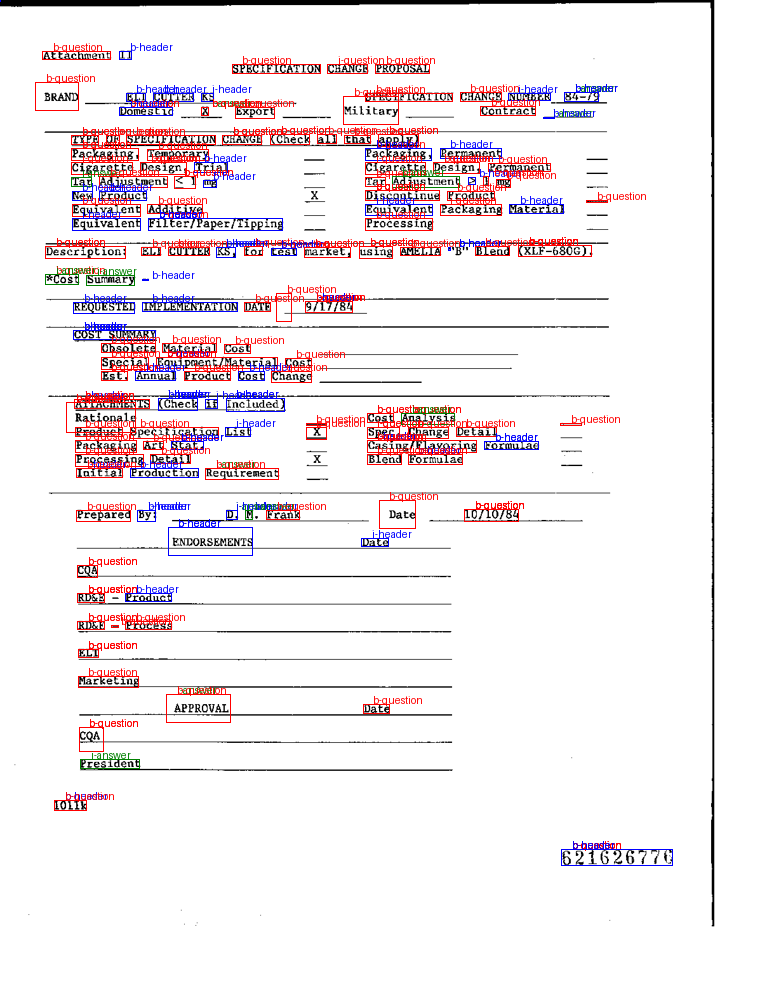

In [85]:
from transformers import LayoutLMForTokenClassification, LayoutLMv2Processor, LayoutLMv2FeatureExtractor, LayoutLMv2TokenizerFast
from PIL import Image, ImageDraw, ImageFont
import torch


# load model and processor from huggingface hub
# You are supposed to load your own trained model here
model = LayoutLMForTokenClassification.from_pretrained("nielsr/layoutlmv2-finetuned-funsd")
print(model.config)
processor = LayoutLMv2Processor.from_pretrained("microsoft/layoutlmv2-base-uncased",apply_ocr=True)
feature_extractor = LayoutLMv2FeatureExtractor.from_pretrained("microsoft/layoutlmv2-base-uncased")
tokenizer = LayoutLMv2TokenizerFast.from_pretrained("microsoft/layoutlmv2-base-uncased",apply_ocr=True)


# helper function to unnormalize bboxes for drawing onto the image
def unnormalize_box(bbox, width, height):
    return [
        width * (bbox[0] / 1000),
        height * (bbox[1] / 1000),
        width * (bbox[2] / 1000),
        height * (bbox[3] / 1000),
    ]


label2color = {
    "b-header": "blue",
    "i-header": "blue",
    "b-question": "red",
    "i-question": "red",
    "b-answer": "green",
    "i-answer": "green",
    "other": "black"  # Optional default color for 'other' labels
}

# draw results onto the image
def draw_boxes(image, boxes, predictions):
    width, height = image.size
    normalizes_boxes = [unnormalize_box(box, width, height) for box in boxes]

    # draw predictions over the image
    draw = ImageDraw.Draw(image)
    font = ImageFont.load_default()
    for prediction, box in zip(predictions, normalizes_boxes):
        if prediction == "O":
            continue
        draw.rectangle(box, outline="black")
        draw.rectangle(box, outline=label2color[prediction])
        draw.text((box[0] + 10, box[1] - 10), text=prediction, fill=label2color[prediction], font=font)
    return image


# run inference
def run_inference(path, model=model, processor=processor, output_image=True):
    # create model input
    image = Image.open(path).convert("RGB")
    encoding = processor(image, return_tensors="pt")
    print(encoding)
    del encoding["image"]
    # run inference
    outputs = model(**encoding)

    predictions = outputs.logits.argmax(-1).squeeze().tolist()
    # get labels
    labels = [model.config.id2label[prediction] for prediction in predictions]
    words = encoding.get("words",None)
    if output_image:
        return draw_boxes(image, encoding["bbox"][0], labels)
    else:
        return labels,words


new_image = run_inference(dataset["train"][29]["image_path"])
new_image


In [76]:
from transformers import LayoutLMForTokenClassification, LayoutLMv2Processor, LayoutLMv2FeatureExtractor, LayoutLMv2TokenizerFast
from PIL import Image, ImageDraw, ImageFont
import torch
import numpy as np

# Load model and processor from Hugging Face hub
model = LayoutLMForTokenClassification.from_pretrained("philschmid/layoutlm-funsd")
processor = LayoutLMv2Processor.from_pretrained("microsoft/layoutlmv2-base-uncased", apply_ocr=False)
feature_extractor = LayoutLMv2FeatureExtractor.from_pretrained("microsoft/layoutlmv2-base-uncased")
tokenizer = LayoutLMv2TokenizerFast.from_pretrained("microsoft/layoutlmv2-base-uncased", apply_ocr=False)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Unnormalize bounding boxes for drawing
def unnormalize_box(bbox, width, height):
    return [
        width * (bbox[0] / 1000),
        height * (bbox[1] / 1000),
        width * (bbox[2] / 1000),
        height * (bbox[3] / 1000),
    ]

label2color = {
    "B-HEADER": "blue",
    "B-QUESTION": "red",
    "B-ANSWER": "green",
    "I-HEADER": "blue",
    "I-QUESTION": "red",
    "I-ANSWER": "green",
}

# Run inference and extract words with labels
def run_inference(image_path):
    # Load image
    image = Image.open(image_path).convert("RGB")

    # Extract features
    encoding_ft = feature_extractor(image, return_tensors="pt")
    words, boxes = encoding_ft.words, encoding_ft.boxes
    print("Words =", words)

    # Process image and words
    encoding = processor(image, words, boxes=boxes, return_tensors="pt", truncation=True)
    del encoding["image"]  # Remove image data from encoding

    # Send inputs to the correct device
    encoding = {k: v.to(device) for k, v in encoding.items()}

    # Run model inference
    outputs = model(**encoding)  # Ensure only relevant inputs are passed

    # Get predictions
    predictions = outputs.logits.argmax(-1).squeeze().tolist()
    token_boxes = encoding['bbox'].squeeze().tolist()  # Access bbox as a dictionary key

    # Identify true predictions and associated boxes
    true_predictions = [model.config.id2label[pred] for pred in predictions]
    true_boxes = [unnormalize_box(box, image.width, image.height) for box in token_boxes]

    print(true_predictions)
    # Collect results
    results = {}
    for label, box, word in zip(true_predictions, true_boxes, words):
        if label != 'O':  # Exclude 'O' predictions
            if label not in results:
                results[label] = word
            else:
                results[label] += ' ' + word

    return results, image

# Example usage
image_path = dataset["train"][30]["image_path"]  # Adjust based on your dataset
d, annotated_image = run_inference(image_path)

image


/usr/local/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
/usr/local/lib/python3.10/site-packages/transformers/models/layoutlmv2/feature_extraction_layoutlmv2.py:30: FutureWarning: The class LayoutLMv2FeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use LayoutLMv2ImageProcessor instead.
  warnings.warn(


Words = [['‘AARBERG-STRAHAN', 'INKS', '&', 'COATINGS', 'CORP.', 'Foraula', 'Composit', 'Forn', 'RECEIVED', 'Customer', 'Be', 'a', 'Product', 'Name__Falcon', 'Green', 'DEC', '1', '1', '1989', 'Formula', 'No.', '__', 'sxoc-4518', 'A.C.', 'D.', 'Solids', 'Composit', '———ecithin', '(Food', 'Grade)', 'Epoxidized', 'Soy', 'Bean', 'O41', 'Cellulose', 'Nitrate', 'Wet', 'w/2', 'Propangl', '-', '——Piament,', 'Blue', '15:4', '00', '—_—intercefitintifimttricyite-Gerbowite-actd', 'Jonrex', 'THP2/', 'oe', 'eee', 'Se', 'ee', 'ee', 'Se', 'Total', 'Solids', 'Solvent', 'Composit', 'to', '%', 'V.0.C.s', 'Toluene', '——Toluene', 'Isopropyl', 'Acetate', 'N-Propyl', 'Acetate', 'eee', 'ee', 'eee', 'Total', 'v.0.C.', '100.0%', 'Technictan___PLR', '12/5/89', '608110969']]
Extracted Labels and Words in JSON: {'Questions': [], 'Answers': []}


display-im6.q16: unable to open X server `' @ error/display.c/DisplayImageCommand/412.


In [17]:
# Getting the output in json format

def extract_qa(labels, words):
    qa_pairs = []
    current_question = ""
    current_answer = ""
    for label, word in zip(labels, words):
        if "QUESTION" in label:
            current_question += word + " "
        elif "ANSWER" in label:
            current_answer += word + " "
        if current_question and current_answer:
            qa_pairs.append({"question": current_question.strip(), "answer": current_answer.strip()})
            current_question = ""
            current_answer = ""
    return qa_pairs
    
# Example use case
result_labels = run_inference(dataset["test"][34]["image_path"], output_image=False)
qa_data = extract_qa(result_labels, your_words_list)

# Save to JSON
import json
with open("output.json", "w") as f:
    json.dump(qa_data, f, indent=4)
